In [1]:
%pylab inline
import scanpy as sc
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def main_gene_selection(X_df, gene_list):
    """
    Describe:
        rebuild the input adata to select target genes encode protein 
    Parameters:
        adata->`~anndata.AnnData` object: adata with var index_name by gene symbol
        gene_list->list: wanted target gene 
    Returns:
        adata_new->`~anndata.AnnData` object
        to_fill_columns->list: zero padding gene
    """
    # to_fill = np.setdiff1d(gene_list, adata.var.index.values) # generate to fill list
    to_fill_columns = list(set(gene_list) - set(X_df.columns))
    padding_df = pd.DataFrame(np.zeros((X_df.shape[0], len(to_fill_columns))), 
                              columns=to_fill_columns, 
                              index=X_df.index)
    #     df = pd.concat([X_df, padding_df], axis=1)
    X_df = pd.DataFrame(np.concatenate([df.values for df in [X_df, padding_df]], axis=1), 
                        index=X_df.index, 
                        columns=list(X_df.columns) + list(padding_df.columns))
    X_df = X_df[gene_list]
    
    var = pd.DataFrame(index=X_df.columns)
    var['mask'] = [1 if i in to_fill_columns else 0 for i in list(var.index)]
    return X_df, to_fill_columns,var
gene_list_df = pd.read_csv('../OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])

In [12]:
df = pd.read_csv('cellbygene.csv.pure.zip',index_col=0,sep=',')

In [13]:
df.index

Index(['b_cells:AAACATACAATGCC_1', 'b_cells:AAACATACACGCAT_1',
       'b_cells:AAACATACGAATAG_1', 'b_cells:AAACATACGTGTCA_1',
       'b_cells:AAACATTGGCCCTT_1', 'b_cells:AAACATTGTTTGGG_1',
       'b_cells:AAACCGTGTGCATG_1', 'b_cells:AAACGCACCCAGTA_1',
       'b_cells:AAACGCACGCCCTT_1', 'b_cells:AAACGCACGTACCA_1',
       ...
       'regulatory_t:TTTCGAACCACTAG_1', 'regulatory_t:TTTCGAACGACAAA_1',
       'regulatory_t:TTTCTACTCAATCG_1', 'regulatory_t:TTTCTACTCCAGTA_1',
       'regulatory_t:TTTCTACTGTTTGG_1', 'regulatory_t:TTTCTACTTCAGTG_1',
       'regulatory_t:TTTGACTGCATGCA_1', 'regulatory_t:TTTGACTGCTACCC_1',
       'regulatory_t:TTTGACTGTCAAGC_1', 'regulatory_t:TTTGCATGTAACCG_1'],
      dtype='object', length=59620)

In [29]:
X_df, to_fill_columns,var = main_gene_selection(df,gene_list)
scipy.sparse.save_npz('pbmc68ksorted_count.npz',scipy.sparse.csr_matrix(X_df.values))

In [32]:
np.save('label.npy',np.array(X_df.index.str.extract(r'([^:]+)', expand=False)))

In [3]:
import scipy.sparse
X_df = scipy.sparse.load_npz('pbmc68ksorted_count.npz')

/tmp/ipykernel_7244/4000295588.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rawadata =sc.AnnData(X_df)


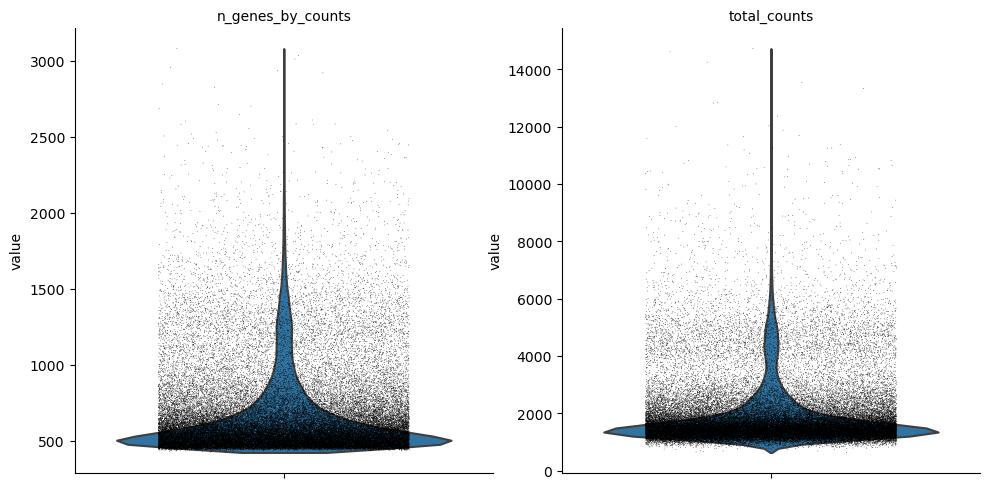

In [4]:
rawadata =sc.AnnData(X_df)

sc.pp.calculate_qc_metrics(rawadata, percent_top=None, log1p=False, inplace=True)

sc.pl.violin(rawadata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.3, multi_panel=True,size=0.5,save='Zheng68K_counts')

# Evaluation

In [5]:
def postprocess(adata,view=True):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    print('after select HVG',adata.shape)
    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    if view:
        sc.tl.umap(adata)
    return adata

In [6]:
def cluster_k_leiden(embadata,n_cluster):
    max_steps=120
    this_step = 0
    this_min = 0
    this_max = 1
    print('reference cluster number',n_cluster)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(embadata,resolution=this_resolution,random_state=42)
        this_clusters = embadata.obs['leiden'].nunique()
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:break
        this_step+=1
    if this_step==max_steps:
        print('Cannot find the number of clusters')
        print('Use resolution',this_resolution)
    else:
        print('use resolution',this_resolution)
     # leiden
    sc.tl.leiden(embadata,resolution=this_resolution,random_state=42,key_added=f'cluster_{n_cluster}')

In [7]:
label = np.load('label.npy',allow_pickle=True)

In [8]:
pd.DataFrame(label).value_counts()

cd34               9162
cytotoxic_t        7631
cd56_nk            7555
cd4_t_helper       7046
memory_t           6969
regulatory_t       6485
naive_cytotoxic    5672
naive_t            4569
b_cells            4033
cd14_monocytes      498
dtype: int64

In [9]:
adata = sc.AnnData(X_df)

adata = postprocess(adata)

sc.tl.leiden(adata,resolution=0.4)

adata.obs['label']=label

/tmp/ipykernel_7244/1117346119.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X_df)


after select HVG (59620, 1067)


/home/minsheng_2022/anaconda3/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
imputeemb = np.load('pbmc68ksorted_count_50M-0.1B-res_tgthighres1.0_embedding.npy')

numcls = np.unique(label).shape[0]

imputeAdata = sc.AnnData(pd.DataFrame(imputeemb))
sc.pp.scale(imputeAdata)
sc.tl.pca(imputeAdata)
sc.pp.neighbors(imputeAdata)
sc.tl.umap(imputeAdata)
imputeAdata.obs['label']=label.tolist()

/home/minsheng_2022/anaconda3/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
sc.settings.figdir='./'

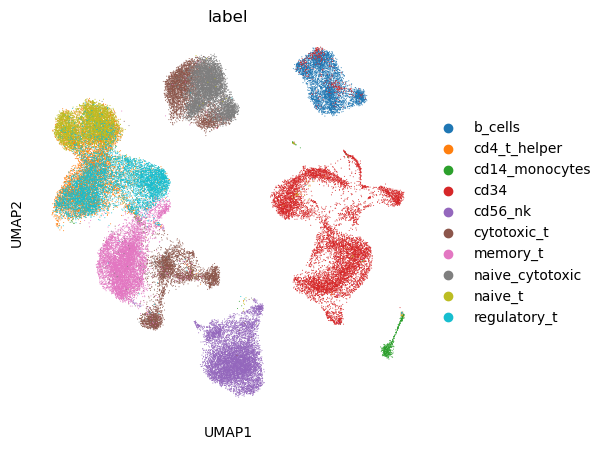

In [12]:
figsize(5,5)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.umap(imputeAdata,color='label')

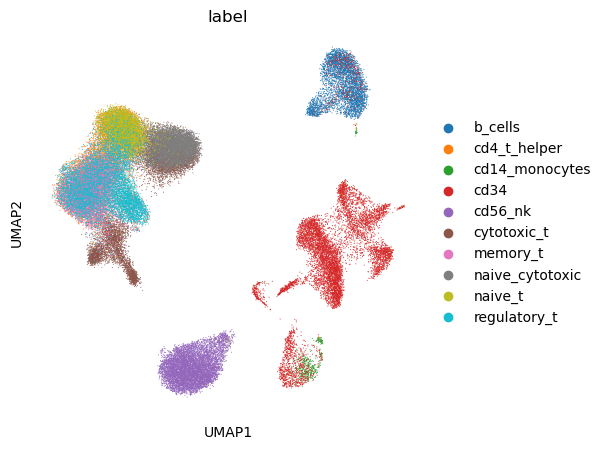

In [13]:
figsize(5,5)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.umap(adata,color='label')

In [14]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score

In [15]:
scvi = pd.read_csv('scVI_latent.csv',sep='\t').T

In [16]:
scviAdata = sc.AnnData(scvi)
sc.pp.scale(scviAdata)
sc.tl.pca(scviAdata)
sc.pp.neighbors(scviAdata)

/tmp/ipykernel_7244/1768682267.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  scviAdata = sc.AnnData(scvi)


In [17]:
sc.tl.leiden(scviAdata,resolution=0.3)
len(scviAdata.obs.leiden.unique())

10

In [18]:
scviAdata.obs['label']=label.tolist()

In [19]:
adatalist=[adata,scviAdata]

In [20]:
silscore=[]
nmiscore=[]
ariscore=[]

for tmpadata in adatalist:
    silscore.append(silhouette_score(tmpadata.obsm['X_pca'],label))
    nmiscore.append(normalized_mutual_info_score(tmpadata.obs['leiden'], label))
    ariscore.append(adjusted_rand_score(tmpadata.obs['leiden'], label))    

In [21]:
scnmiscore=[]
scariscore=[]
scsilscore=[]
for i in [0,1]:
    print(i)
    if i ==0:
        imputeemb = np.load('pbmc68ksorted_count_50M-0.1B-res_embedding.npy')
    else:
        imputeemb = np.load(f'pbmc68ksorted_count_50M-0.1B-res_tgthighres{i:.1f}_embedding.npy')        
    imputeAdata = sc.AnnData(pd.DataFrame(imputeemb))
    sc.pp.scale(imputeAdata)
    sc.tl.pca(imputeAdata)
    sc.pp.neighbors(imputeAdata)
    cluster_k_leiden(imputeAdata,numcls)
    scnmiscore.append(normalized_mutual_info_score(imputeAdata.obs['leiden'], label))
    scariscore.append(adjusted_rand_score(imputeAdata.obs['leiden'], label))    
    scsilscore.append(silhouette_score(imputeAdata.obsm['X_pca'],label))

0


/home/minsheng_2022/anaconda3/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reference cluster number 10
use resolution 0.1875
1


/home/minsheng_2022/anaconda3/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reference cluster number 10
use resolution 0.171875


In [22]:
df = pd.DataFrame([nmiscore+[scnmiscore[1]],ariscore+[scariscore[1]],silscore+[scsilscore[1]]],index=['NMI','ARI','SIL'],columns=['Raw','scVI','scFoundation'])
df['name']=df.index
df = df.melt(id_vars='name')

Text(0.5, 1.0, 'PBMC68K')

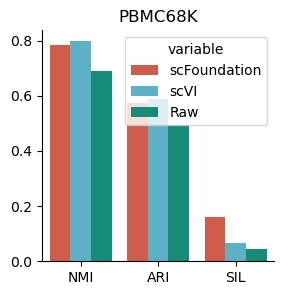

In [23]:
import seaborn as sns
import colorbm as cbm
sns.set_palette(sns.color_palette(cbm.pal('npg').as_hex))
figsize(3,3)
rcParams['axes.spines.left'] = True
rcParams['axes.spines.bottom'] = True
sns.barplot(data=df,x='name',y='value',hue='variable',hue_order=['scFoundation','scVI','Raw'])
plt.xlabel(None)
plt.ylabel(None);
plt.title('PBMC68K')